In [25]:
import pandas as pd
import numpy as np
from datetime import datetime
import itertools
from collections import Counter
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

from transformers import pipeline

# 분석

In [112]:
# 전처리된 파일 가져와라 (전처리는 이 노트북에 하지 않습니다)

path = '../data/'
fn = 'news_202504_cleaned_summarized'
very_raw_data = pd.read_csv(path+fn+'.csv', index_col=0)

In [113]:
raw_data = very_raw_data.copy()
raw_data.rename(columns={'sid2_name':'category'}, inplace=True)

In [114]:
raw_data.groupby('category').count()

,index,sid1_name,date,title,content,href,content_cleaned,content_summarized
category,,,,,,,,
경제 일반,9454,9454,9454,9454,9454,9454,9454,9454
글로벌 경제,444,444,444,444,444,444,444,444
금융,1791,1791,1791,1791,1791,1791,1791,1791
부동산,2247,2247,2247,2247,2247,2247,2247,2247
산업/재계,4309,4309,4309,4309,4309,4309,4309,4309
중기/벤처,692,692,692,692,692,692,692,692


In [115]:
#raw_data = raw_data.loc[raw_data.category=='금융']

In [116]:
df_data = raw_data[['category','date','title','content_summarized']].copy()
df_data['date'] = df_data['date'].astype(str)

In [117]:
df_data

,category,date,title,content_summarized
0,경제 일반,20250430,3년 전 국민연금 콕 찝은 美 재무부…베센트의 선택은? [Pick코노미],2022년 미국 재무부 환율보고서에서 국민연금의 해외투자 확대가 원화 약세의 구조적...
1,부동산,20250430,신규수주 잠정 중단 선언한 현대엔지…사명 변경도 추진,현대엔지니어링은 서울-세종 고속도로 교량 붕괴 등 잇따른 건설사고로 인해 안전 시스...
2,산업/재계,20250430,"신동빈 롯데 회장, 베트남 하노이 방문…‘롯데몰 웨스트레이크’ 현장 방문",신동빈 롯데그룹 회장이 인도네시아 자카르타 방문에 이어 베트남 하노이 롯데몰 웨스트...
3,중기/벤처,20250430,"네스틱, 자석놀이 출시…유아 교육완구 시장 진출",프리미엄 유아 식기 브랜드 네스틱이 대표 제품 ‘토끼 원 플레이트’ 디자인을 적용한...
4,경제 일반,20250430,정부 “사망사고 항공사에 1년간 ‘신규 운수권’ 배분 중단”,국토교통부는 지난해 12월 무안국제공항 제주항공 참사를 계기로 항공안전 혁신 방안을...
...,...,...,...,...
18932,경제 일반,20250401,"트럼프 “반도체법, 전 정부보다 나은 협상할 것”…지갑 닫은 삼성 ‘딜레마’",미국 정부가 반도체 보조금 재협상을 시사하며 삼성전자에 투자 확대나 보조금 축소를 ...
18933,경제 일반,20250401,"모스토리를 움직이는 모션그래픽 디자이너, 정현수",뉴욕에서 활동하는 모션 그래픽 디자이너 정현수는 더 워킹 어셈블리에서 브랜드 정체성...
18934,경제 일반,20250401,머릿속 비밀풀어 인간과 동물처럼 의심하는 AI개발,이상완 카이스트 뇌인지과학과 교수는 인간 뇌의 복잡한 고차원적 기능을 AI 알고리즘...
18935,글로벌 경제,20250401,美 3월 제조업 PMI 위축·공장 출고가 급등…인플레 예고,3월 미국 제조업 PMI가 2월 50.3에서 49.0으로 하락하며 제조업 부문이 위...


In [118]:
lst_summarized_doc = df_data["content_summarized"].dropna()
ind = lst_summarized_doc.index
lst_summarized_doc = lst_summarized_doc.tolist()
len(lst_summarized_doc)

18937

In [119]:
lst_title_doc = df_data["title"].dropna()
ind = lst_title_doc.index
lst_title_doc = lst_title_doc.tolist()
len(lst_title_doc)

18937

In [120]:
metadata_df = pd.DataFrame(lst_title_doc, columns=['title'])
metadata_df['category'] = df_data.category[ind].to_list()
metadata_df['date'] = df_data.date[ind].to_list()
metadata_df['content_summarized'] = df_data.content_summarized[ind].to_list()

In [121]:
metadata_df

,title,category,date,content_summarized
0,3년 전 국민연금 콕 찝은 美 재무부…베센트의 선택은? [Pick코노미],경제 일반,20250430,2022년 미국 재무부 환율보고서에서 국민연금의 해외투자 확대가 원화 약세의 구조적...
1,신규수주 잠정 중단 선언한 현대엔지…사명 변경도 추진,부동산,20250430,현대엔지니어링은 서울-세종 고속도로 교량 붕괴 등 잇따른 건설사고로 인해 안전 시스...
2,"신동빈 롯데 회장, 베트남 하노이 방문…‘롯데몰 웨스트레이크’ 현장 방문",산업/재계,20250430,신동빈 롯데그룹 회장이 인도네시아 자카르타 방문에 이어 베트남 하노이 롯데몰 웨스트...
3,"네스틱, 자석놀이 출시…유아 교육완구 시장 진출",중기/벤처,20250430,프리미엄 유아 식기 브랜드 네스틱이 대표 제품 ‘토끼 원 플레이트’ 디자인을 적용한...
4,정부 “사망사고 항공사에 1년간 ‘신규 운수권’ 배분 중단”,경제 일반,20250430,국토교통부는 지난해 12월 무안국제공항 제주항공 참사를 계기로 항공안전 혁신 방안을...
...,...,...,...,...
18932,"트럼프 “반도체법, 전 정부보다 나은 협상할 것”…지갑 닫은 삼성 ‘딜레마’",경제 일반,20250401,미국 정부가 반도체 보조금 재협상을 시사하며 삼성전자에 투자 확대나 보조금 축소를 ...
18933,"모스토리를 움직이는 모션그래픽 디자이너, 정현수",경제 일반,20250401,뉴욕에서 활동하는 모션 그래픽 디자이너 정현수는 더 워킹 어셈블리에서 브랜드 정체성...
18934,머릿속 비밀풀어 인간과 동물처럼 의심하는 AI개발,경제 일반,20250401,이상완 카이스트 뇌인지과학과 교수는 인간 뇌의 복잡한 고차원적 기능을 AI 알고리즘...
18935,美 3월 제조업 PMI 위축·공장 출고가 급등…인플레 예고,글로벌 경제,20250401,3월 미국 제조업 PMI가 2월 50.3에서 49.0으로 하락하며 제조업 부문이 위...


## Sentiment Classification Using BERT

- model used: 
  - snunlp/KR-FinBert-SC

https://huggingface.co/snunlp/KR-FinBert-SC

In [122]:
# model
model_name = 'snunlp/KR-FinBert-SC'
classifier = pipeline("sentiment-analysis", model=model_name, device='cuda')

Device set to use cuda


In [123]:
results = classifier(lst_title_doc)

In [124]:
sentiments_df = pd.DataFrame(results)
sentiments_df['label'] = sentiments_df['label'].map({
    'positive': '긍정',
    'negative': '부정',
    'neutral': '중립'
})

# score 컬럼명을 senti_score로 변경
sentiments_df.rename(columns={'score': 'senti_score'}, inplace=True)

In [125]:
metadata_df = pd.concat([metadata_df.reset_index(drop=True), sentiments_df], axis=1)
metadata_df

,title,category,date,content_summarized,label,senti_score
0,3년 전 국민연금 콕 찝은 美 재무부…베센트의 선택은? [Pick코노미],경제 일반,20250430,2022년 미국 재무부 환율보고서에서 국민연금의 해외투자 확대가 원화 약세의 구조적...,중립,0.999751
1,신규수주 잠정 중단 선언한 현대엔지…사명 변경도 추진,부동산,20250430,현대엔지니어링은 서울-세종 고속도로 교량 붕괴 등 잇따른 건설사고로 인해 안전 시스...,부정,0.996060
2,"신동빈 롯데 회장, 베트남 하노이 방문…‘롯데몰 웨스트레이크’ 현장 방문",산업/재계,20250430,신동빈 롯데그룹 회장이 인도네시아 자카르타 방문에 이어 베트남 하노이 롯데몰 웨스트...,중립,0.999829
3,"네스틱, 자석놀이 출시…유아 교육완구 시장 진출",중기/벤처,20250430,프리미엄 유아 식기 브랜드 네스틱이 대표 제품 ‘토끼 원 플레이트’ 디자인을 적용한...,긍정,0.999877
4,정부 “사망사고 항공사에 1년간 ‘신규 운수권’ 배분 중단”,경제 일반,20250430,국토교통부는 지난해 12월 무안국제공항 제주항공 참사를 계기로 항공안전 혁신 방안을...,부정,0.999067
...,...,...,...,...,...,...
18932,"트럼프 “반도체법, 전 정부보다 나은 협상할 것”…지갑 닫은 삼성 ‘딜레마’",경제 일반,20250401,미국 정부가 반도체 보조금 재협상을 시사하며 삼성전자에 투자 확대나 보조금 축소를 ...,중립,0.996437
18933,"모스토리를 움직이는 모션그래픽 디자이너, 정현수",경제 일반,20250401,뉴욕에서 활동하는 모션 그래픽 디자이너 정현수는 더 워킹 어셈블리에서 브랜드 정체성...,중립,0.999569
18934,머릿속 비밀풀어 인간과 동물처럼 의심하는 AI개발,경제 일반,20250401,이상완 카이스트 뇌인지과학과 교수는 인간 뇌의 복잡한 고차원적 기능을 AI 알고리즘...,중립,0.999688
18935,美 3월 제조업 PMI 위축·공장 출고가 급등…인플레 예고,글로벌 경제,20250401,3월 미국 제조업 PMI가 2월 50.3에서 49.0으로 하락하며 제조업 부문이 위...,중립,0.999850


In [126]:
metadata_df.to_csv('news_sentiment_202504.csv', encoding='utf-8-sig')

In [130]:
senti_df = metadata_df.copy()

# 감성(label) 개수 계산
sentiment_counts = senti_df['label'].value_counts()

# 감성(label) 비율 계산
sentiment_ratios = senti_df['label'].value_counts(normalize=True)

# 결과를 하나의 DataFrame으로 정리
summary_df = pd.DataFrame({
    'count': sentiment_counts,
    'ratio': sentiment_ratios
}).reset_index().rename(columns={'index': 'sentiment'})

print(summary_df)

  label  count     ratio
0    중립  12422  0.655965
1    긍정   4134  0.218303
2    부정   2381  0.125733


In [131]:
senti_df['date'] = pd.to_datetime(senti_df['date'])

# 감성(label)의 개수 및 비율 (옵션, 참고용)
daily_counts = senti_df.groupby(['date', 'label']).size().unstack(fill_value=0)
daily_ratios = daily_counts.div(daily_counts.sum(axis=1), axis=0)

# 감성지수 계산을 위해 점수 매핑 (긍정:1, 중립:0, 부정:-1)
sentiment_score_mapping = {'긍정': 1, '중립': 0, '부정': -1}
senti_df['mapped_label'] = senti_df['label'].map(sentiment_score_mapping)

# 일자별로 weighted sentiment 계산 (label 점수 * senti_score)
senti_df['weighted_score'] = senti_df['mapped_label'] * senti_df['senti_score']

# 일자별 감성지수 계산 (weighted_score의 평균)
daily_sentiment_index = senti_df.groupby('date')['weighted_score'].mean().reset_index()
daily_sentiment_index.rename(columns={'weighted_score': 'news_sentiment_index'}, inplace=True)

In [133]:
daily_sentiment_index

,date,news_sentiment_index
0,2025-04-01,0.063677
1,2025-04-02,0.151253
2,2025-04-03,0.044557
3,2025-04-04,-0.015135
4,2025-04-05,-0.049328
5,2025-04-06,0.028236
6,2025-04-07,0.045549
7,2025-04-08,0.109883
8,2025-04-09,0.084007
9,2025-04-10,0.085910


<Axes: xlabel='date'>

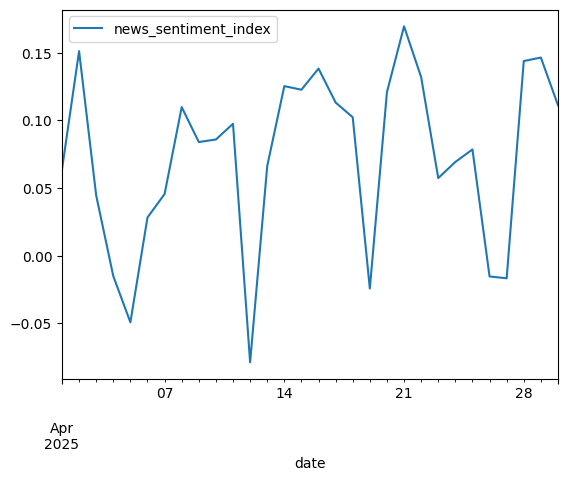

In [132]:
daily_sentiment_index.set_index('date').plot()